In [23]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

os.environ['KMP_DUPLICATE_LIB_OK']='True'
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [24]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4363,-118.02,33.96,36.0,2002.0,361.0,913.0,311.0,4.5446,244700.0
6809,-118.30,34.07,36.0,2657.0,738.0,2274.0,723.0,3.4250,281700.0
2115,-117.35,33.98,31.0,4163.0,1242.0,3928.0,1076.0,1.6943,85900.0
8977,-118.92,34.40,23.0,1290.0,283.0,1060.0,279.0,3.3152,198000.0
11996,-121.39,38.58,41.0,2577.0,365.0,913.0,339.0,6.3406,448300.0


In [25]:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [26]:
feature_cols = []

resolution_in_Zs = 0.3 # 3/10 dari std

lat_as_num_col = tf.feature_column.numeric_column("latitude")
lat_boundaries = list(
    np.arange(
        int(min(train_df_norm["latitude"])),
        int(max(train_df_norm["latitude"])),
        resolution_in_Zs,
    ),
)
latitude = tf.feature_column.bucketized_column(
    lat_as_num_col,
    boundaries=lat_boundaries,
)

long_as_num_col = tf.feature_column.numeric_column("longitude")
long_boundaries = list(
    np.arange(
        int(min(train_df_norm["longitude"])),
        int(max(train_df_norm["longitude"])),
        resolution_in_Zs,
    ),
)
longitude = tf.feature_column.bucketized_column(
    long_as_num_col,
    boundaries=long_boundaries
)

lat_x_long = tf.feature_column.crossed_column(
    [latitude, longitude],
    hash_bucket_size=int(1e6),
)
crossed_feature = tf.feature_column.indicator_column(
    lat_x_long,
)
feature_cols.append(crossed_feature)

median_income = tf.feature_column.numeric_column("median_income")
feature_cols.append(median_income)

population = tf.feature_column.numeric_column("population")
feature_cols.append(population)

feature_layer = tf.keras.layers.DenseFeatures(feature_cols)
feature_layer

In [27]:
def plot_curve(_epochs, _mse):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("MSE")

    plt.plot(_epochs, _mse, label="Loss")
    plt.legend()
    plt.ylim([_mse.min() * 0.95, _mse.max() * 1.05])
    plt.show()

In [28]:
def create_model(_learning_rate, _feature_layer):
    _model = tf.keras.models.Sequential()
    _model.add(_feature_layer)
    _model.add(tf.keras.layers.Dense(
        units=20,
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.04),
        name="Hidden1",
    ))
    _model.add(tf.keras.layers.Dense(
        units=12,
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.04),
        name="Hidden2",
    ))
    _model.add(tf.keras.layers.Dense(
        units=1,
        activation="relu",
        name="Output",
    ))
    _model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.MeanSquaredError()],
    )
    return _model

def train_model(_model, _dataset, _epochs, _batch_size, _label):
    _features = {
        name: np.array(value) for name, value in _dataset.items() if name != _label
    }
    _label = np.array(_dataset[_label])
    _history = _model.fit(
        x=_features,
        y=_label,
        epochs=_epochs,
        batch_size=_batch_size,
    )
    _trained_epochs = _history.epoch
    _hist = pd.DataFrame(_history.history)
    _mse = _hist["mean_squared_error"]
    return _trained_epochs, _mse

Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 30s 2s/step - loss: 12.1462 - mean_squared_error: 0.7731
Epoch 2/15
17/17 [==============================] - 27s 2s/step - loss: 2.3518 - mean_squared_error: 0.6246
Epoch 3/15
17/17 [==============================] - 27s 2s/step - loss: 1.0060 - mean_squared_error: 0.6263
Epoch 4/15
17/17 [==============================] - 25s 1s/step - loss: 0.7269 - mean_squared_error: 0.6200
Epoch 5/15
17/17 [==============================] - 26s 2s/step - loss: 0.6752 - mean_squared_error: 0.6163
Epoch 6/15
17/17 [==============================] - 26s 2s/step - loss: 0.6603 - mean_squared_error: 0.6145
Epoch 7/15
17/17 [==============================] - 28s 2s/step - loss: 0.6552 - mean_squared_error: 0.6109
Epoch 8/15
17/17 [==============================] - 25s 1s/step - loss: 0.6502 - mean_squared_error: 0.6094
Epoch 9/15
17/17 [=======

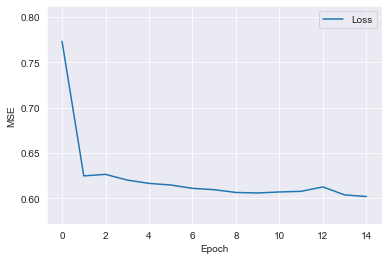

Consider rewriting this model with the Functional API.
94/94 [==============================] - 7s 69ms/step - loss: 0.6542 - mean_squared_error: 0.6197


[0.6542012095451355, 0.6196721196174622]

In [29]:
learning_rate = 0.01
epochs = 15
batch_size = 1000
label = "median_house_value"

model = create_model(learning_rate, feature_layer)
trained_epochs, mse = train_model(model, train_df_norm, epochs, batch_size, label)
plot_curve(trained_epochs, mse)

test_features = {
    name: np.array(value) for name, value in test_df_norm.items() if name != label
}
test_label = np.array(test_df_norm[label])
model.evaluate(x=test_features, y=test_label)